In [4]:
# Cell 1: Import libraries, Serper.dev integration, and load API keys
import os
import json
import requests
from typing import Dict, List, Any
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph, END
from typing import TypedDict
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re

class SerperSearch:
    """
    Serper.dev wrapper class compatible with TavilySearch interface
    """
    
    def __init__(self, max_results: int = 3, search_type: str = "search"):
        self.max_results = max_results
        self.search_type = search_type
        self.api_key = os.getenv("SERPER_API_KEY")
        
        if not self.api_key:
            raise ValueError("SERPER_API_KEY environment variable is required")
        
        self.base_url = "https://google.serper.dev"
        
    def invoke(self, input_dict: Dict[str, str]) -> Dict[str, Any]:
        query = input_dict.get("query", "")
        
        if not query:
            return {"query": "", "results": []}
        
        try:
            response = self._search(query)
            transformed_results = self._transform_results(response, query)
            return transformed_results
            
        except Exception as e:
            print(f"Serper search error: {str(e)}")
            return {"query": query, "results": [], "error": str(e)}
    
    def _search(self, query: str) -> Dict[str, Any]:
        url = f"{self.base_url}/{self.search_type}"
        
        payload = {
            "q": query,
            "num": self.max_results,
            "hl": "en",
            "gl": "us"
        }
        
        headers = {
            "X-API-KEY": self.api_key,
            "Content-Type": "application/json"
        }
        
        response = requests.post(url, json=payload, headers=headers)
        response.raise_for_status()
        
        return response.json()
    
    def _transform_results(self, serper_response: Dict[str, Any], query: str) -> Dict[str, Any]:
        results = []
        
        organic_results = serper_response.get("organic", [])
        
        for result in organic_results[:self.max_results]:
            transformed_result = {
                "url": result.get("link", ""),
                "title": result.get("title", ""),
                "content": result.get("snippet", "")
            }
            results.append(transformed_result)
        
        return {
            "query": query,
            "follow_up_questions": None,
            "answer": None,
            "images": [],
            "results": results
        }

# Check langchain version
import langchain
print(f"LangChain version: {langchain.__version__}")

# Load .env
load_dotenv()

# Verify API keys
serper_key = os.getenv("SERPER_API_KEY")
openai_key = os.getenv("OPENAI_API_KEY")
print("Serper API Key:", "Loaded" if serper_key else "Not found")
print("OpenAI API Key:", "Loaded" if openai_key else "Not found")

# Initialize LLM and Serper
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
search_tool = SerperSearch(max_results=5)

# Test Serper
try:
    test_result = search_tool.invoke({"query": "Who won Wimbledon 2024?"})
    print("Serper Test Result:", str(test_result)[:200], "...")
except Exception as e:
    print("Serper Test Error:", str(e))

LangChain version: 0.3.27
Serper API Key: Loaded
OpenAI API Key: Loaded
Serper Test Result: {'query': 'Who won Wimbledon 2024?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.olympics.com/en/news/wimbledon-2024-mens-singles-final-carlos-alcaraz-r ...


In [8]:
# Cell 2: Load and preprocess dataset
def load_dataset(dataset_path: str, num_samples: int = None) -> pd.DataFrame:
    """Load and preprocess the dataset"""
    print(f"Loading dataset from: {dataset_path}")
    
    # Load dataset
    df = pd.read_csv(dataset_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Display sample data
    print("\nSample data:")
    print(df.head())
    
    # Check label distribution
    print(f"\nLabel distribution:")
    print(df['label'].value_counts())
    
    # Handle different label formats
    if 'label' in df.columns:
        # Standardize labels
        df['label'] = df['label'].str.lower()
        df['label'] = df['label'].map({
            'fake': 'fake',
            'real': 'real', 
            'legitimate': 'real',
            'true': 'real'
        })
    
    # Sample if specified
    if num_samples:
        df = df.sample(n=num_samples, random_state=42).reset_index(drop=True)
        print(f"\nSampled {num_samples} articles")
    
    return df

# Load dataset
dataset_path = 'data/gossipcop.csv'
df = load_dataset(dataset_path, num_samples=2000)

Loading dataset from: data/gossipcop.csv


Dataset shape: (20007, 3)
Columns: ['id', 'text', 'label']

Sample data:
   id                                               text label
0   0  Star magazine has released an explosive report...  fake
1   1  Earlier this year, the buzz around Megyn Kelly...  fake
2   2  For the first time since his involvement in a ...  fake
3   3  Those heels were cute, but they didn't last lo...  fake
4   4  American reality television personality and re...  fake

Label distribution:
label
real    15223
fake     4784
Name: count, dtype: int64

Sampled 2000 articles


In [ ]:
# Cell 3: Define state and IMPROVED entertainment fact-checking prompts
class AgentState(TypedDict):
    text: str
    title: str
    z_output: dict
    z_sources: list
    debate_logs: list
    final_label: str

# JSON parser
json_parser = JsonOutputParser()

# IMPROVED Helper functions cho entertainment fact-checking
def extract_celebrity_claims(text, max_claims=3):
    """Extract specific celebrity claims for targeted fact-checking"""
    import re
    
    # Patterns for celebrity claims
    celebrity_patterns = [
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:said|claimed|announced|revealed|confirmed|denied|admitted)',
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:is|are)\s+(?:dating|married|engaged|pregnant|divorcing)',
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:will|is going to)\s+(?:get married|have a baby|break up)',
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:spotted|seen)\s+(?:with|at)',
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:responded|reacted)\s+(?:to|about)',
        r'([A-Z][a-z]+ [A-Z][a-z]+)\s+(?:exclusive|interview|statement)',
    ]
    
    claims = []
    text_lower = text.lower()
    
    for pattern in celebrity_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            if match and len(match) > 3:
                # Find the full sentence containing this claim
                sentences = text.split('. ')
                for sentence in sentences:
                    if match.lower() in sentence.lower():
                        claims.append({
                            'celebrity': match,
                            'sentence': sentence.strip(),
                            'type': 'relationship' if any(word in sentence.lower() for word in ['dating', 'married', 'engaged', 'pregnant']) else 'statement'
                        })
                        break
    
    return claims[:max_claims]

def create_entertainment_search_queries(claims, content_type="entertainment"):
    """Create targeted search queries for entertainment fact-checking"""
    queries = []
    
    # Add claims-based queries
    for claim in claims:
        celebrity = claim['celebrity']
        claim_type = claim['type']
        
        if claim_type == 'relationship':
            queries.append(f'"{celebrity}" relationship dating marriage site:people.com OR site:hollywoodreporter.com OR site:variety.com')
            queries.append(f'"{celebrity}" denied confirmed site:snopes.com OR site:reuters.com')
        else:
            queries.append(f'"{celebrity}" statement interview site:people.com OR site:hollywoodreporter.com')
            queries.append(f'"{celebrity}" fact check site:snopes.com OR site:reuters.com')
    
    # Add general entertainment fact-checking queries
    if content_type == "entertainment":
        # Extract key phrases for general search
        key_phrases = extract_key_phrases(content, max_phrases=2)
        for phrase in key_phrases:
            queries.append(f'"{phrase}" fact check site:snopes.com OR site:reuters.com OR site:ap.org')
            queries.append(f'"{phrase}" entertainment news site:people.com OR site:hollywoodreporter.com OR site:variety.com')
    
    return queries

def extract_key_phrases(text, max_phrases=5):
    """Extract key phrases/claims từ content để search"""
    import re
    
    # Lấy câu đầu tiên của mỗi paragraph
    paragraphs = text.split('\n\n')
    key_sentences = []
    
    for para in paragraphs[:3]:  # Top 3 paragraphs
        sentences = para.split('. ')
        if sentences and len(sentences[0]) > 20:
            key_sentences.append(sentences[0])
    
    # Tìm câu có chứa tên riêng, số liệu, claims
    claim_patterns = [
        r'[A-Z][a-z]+ (?:said|claimed|announced|revealed|confirmed)',
        r'\d+(?:%|percent)',
        r'(?:million|billion|thousand)',
        r'"[^"]{10,100}"'  # Quoted statements
    ]
    
    important_sentences = []
    all_sentences = text.split('. ')
    
    for sentence in all_sentences[:15]:  # Check first 15 sentences
        for pattern in claim_patterns:
            if re.search(pattern, sentence):
                important_sentences.append(sentence.strip())
                break
    
    # Combine và return unique phrases
    all_key_phrases = key_sentences + important_sentences
    unique_phrases = []
    seen = set()
    
    for phrase in all_key_phrases:
        phrase_lower = phrase.lower()
        if phrase_lower not in seen and len(phrase) > 20:
            unique_phrases.append(phrase)
            seen.add(phrase_lower)
    
    return unique_phrases[:max_phrases]

def summarize_content(text, max_length=1500):
    """Summarize content dài để improve performance"""
    if len(text) <= max_length:
        return text
    
    # Lấy beginning + key parts + end
    parts = []
    
    # Beginning
    parts.append(text[:max_length//3])
    
    # Middle with key information
    middle_start = len(text)//2 - max_length//6
    parts.append(text[middle_start:middle_start + max_length//3])
    
    # End
    parts.append(text[-max_length//3:])
    
    return " [...] ".join(parts)

def detect_content_type(text):
    """Detect if content is entertainment/gossip vs serious news"""
    entertainment_keywords = [
        'celebrity', 'star', 'actor', 'actress', 'singer', 'dating', 'relationship',
        'gossip', 'rumor', 'exclusive', 'revealed', 'confessed', 'admitted',
        'tinder', 'dating app', 'breakup', 'marriage', 'divorce', 'pregnancy',
        'baby', 'wedding', 'engagement', 'affair', 'cheating', 'romance'
    ]
    
    serious_keywords = [
        'government', 'policy', 'election', 'politics', 'economy', 'crime',
        'health', 'science', 'technology', 'business', 'finance', 'war',
        'terrorism', 'climate', 'environment', 'education', 'immigration'
    ]
    
    text_lower = text.lower()
    entertainment_score = sum(1 for word in entertainment_keywords if word in text_lower)
    serious_score = sum(1 for word in serious_keywords if word in text_lower)
    
    if entertainment_score > serious_score:
        return "entertainment"
    else:
        return "serious"

def detect_red_flags(text):
    """Detect red flags in content"""
    text_lower = text.lower()
    
    red_flags = [
        "sources say", "insiders claim", "reportedly", "allegedly",
        "denied by", "representatives denied", "anonymous sources",
        "unnamed sources", "sources close to", "insiders tell",
        "according to sources", "sources tell", "insiders say"
    ]
    
    found_flags = [flag for flag in red_flags if flag in text_lower]
    return found_flags

# IMPROVED Entertainment Fact-Checking Prompts
entertainment_verifier_prompt = ChatPromptTemplate.from_template(
    """You are an entertainment fact-checker analyzing celebrity news and gossip for credibility.

CONTENT TO VERIFY:
{content}

RETRIEVED INFORMATION FROM TRUSTED SOURCES:
{retrieved}

TRUSTED ENTERTAINMENT SOURCES USED:
- PEOPLE Magazine (people.com)
- The Hollywood Reporter (hollywoodreporter.com) 
- Variety (variety.com)
- Snopes Fact Check (snopes.com)
- Reuters Fact Check (reuters.com)
- Associated Press (ap.org)

IMPORTANT CRITERIA for "fake":
1. **Unnamed sources for major claims**: "sources say", "insiders claim", "reportedly"
2. **Claims denied by official representatives**: Celebrity reps, PR teams, or official statements
3. **Contradictions with verified facts**: Claims that contradict official statements or verified events
4. **Sensational claims without evidence**: Dramatic claims without supporting evidence from trusted sources
5. **Anonymous sources for important details**: No named sources for key claims

For entertainment content, ACCEPT as "pass":
- Named celebrity quotes and interviews from trusted sources
- Verified events and public appearances
- Official statements from celebrity representatives
- Confirmed industry information with named sources
- Personal anecdotes from named individuals

REJECT (flag as "fake"):
- Stories relying solely on "sources say" or "insiders claim"
- Claims denied by official representatives
- Contradictions with known facts from trusted sources
- Overly dramatic scenarios without evidence
- Anonymous sources for relationship or personal claims

ANALYSIS: Compare the content claims with information from trusted entertainment sources. Look for:
- Official denials or confirmations
- Named vs unnamed sources
- Consistency with verified facts
- Evidence from reputable entertainment publications

Return JSON: {{"label": "fake" or "pass", "reason": "Detailed analysis with specific evidence from trusted sources"}}
"""
)

# IMPROVED General verifier prompt
verifier_prompt = ChatPromptTemplate.from_template(
    """You are a fact-verifier analyzing news content for credibility.

CONTENT TO VERIFY:
{content}

RETRIEVED INFORMATION:
{retrieved}

TRUSTED SOURCES USED:
- Snopes Fact Check (snopes.com)
- Reuters Fact Check (reuters.com)
- Associated Press (ap.org)
- BBC Fact Check (bbc.com)
- FactCheck.org

IMPORTANT: Be BALANCED, not overly lenient. Flag as "fake" if:

1. **Unnamed sources for major claims**: "sources say", "insiders claim", "reportedly"
2. **Denied claims**: Official representatives have denied the story
3. **Contradictions**: Claims contradict verified facts from trusted sources
4. **Sensational without evidence**: Dramatic claims without supporting evidence
5. **Anonymous sources for important details**: No named sources for key claims

Return JSON: {{"label": "fake" or "pass", "reason": "Detailed verification result with evidence from trusted sources"}}

Examples:
- Story with unnamed sources claiming denied relationship → "fake"
- Article with named quotes and verified events → "pass"
- Gossip denied by representatives → "fake"
- Entertainment news with named sources → "pass"
"""
)

# IMPROVED Agent A/B prompts - balanced approach
fallacy_prompt = ChatPromptTemplate.from_template(
    """You are a logical fallacy expert. Be BALANCED in your analysis.

CONTENT: {text}

IMPORTANT: Flag as "fake" if you find:
1. **Unnamed sources for major claims**: "sources say", "insiders claim"
2. **Denied claims**: Official representatives denied the story
3. **Contradictions**: Claims contradict verified facts
4. **Sensational without evidence**: Dramatic claims without proof
5. **Anonymous sources**: No named sources for important details

For entertainment content, be careful about:
- Celebrity gossip based on unnamed sources
- Relationship rumors without named quotes
- Industry insider claims without verification

Return JSON: {{"label": "fake" or "real", "reason": "Balanced analysis"}}
"""
)

fallacy_prompt_a3 = ChatPromptTemplate.from_template(
    """You are a logical fallacy expert. Refine your analysis of this content.

CONTENT: {text}

COUNTER-ARGUMENT: {counter}

IMPORTANT: Be balanced. Only change to "fake" if you find CLEAR evidence of:
- Unnamed sources for major claims
- Denied claims by official representatives
- Contradictions with verified facts
- Sensational claims without evidence

For entertainment content, be careful about:
- Celebrity gossip based on unnamed sources
- Relationship rumors without named quotes
- Industry insider claims without verification

Return JSON: {{"label": "fake" or "real", "reason": "Balanced refined analysis"}}
"""
)

fake_news_prompt = ChatPromptTemplate.from_template(
    """You are a fake news detector. Be BALANCED.

CONTENT: {text}

COUNTER-ARGUMENT: {counter}

IMPORTANT: Classify as "fake" if:
1. **Unnamed sources**: "sources say", "insiders claim", "reportedly"
2. **Denied claims**: Official representatives denied the story
3. **Contradictions**: Claims contradict verified facts
4. **Sensational without evidence**: Dramatic claims without proof

For entertainment/news, be careful about:
- Celebrity gossip based on unnamed sources
- Relationship rumors without named quotes
- Industry insider claims without verification

Return JSON: {{"label": "fake" or "real", "reason": "Balanced assessment"}}
"""
)

# Create chains
agent_z_chain = verifier_prompt | llm | json_parser
agent_z_entertainment_chain = entertainment_verifier_prompt | llm | json_parser
agent_a_chain = fallacy_prompt | llm | json_parser
agent_a3_chain = fallacy_prompt_a3 | llm | json_parser
agent_b_chain = fake_news_prompt | llm | json_parser

✅ OPTIMAL system ready!


In [ ]:
# Cell 4: Build LangGraph workflow với IMPROVED entertainment fact-checking
def run_z(state: AgentState) -> AgentState:
    print(f"Running Agent Z on content (length: {len(state['text'])} chars)...")
    try:
        # Process content for search
        content = state["text"]
        
        # Detect content type
        content_type = detect_content_type(content)
        print(f"Content type detected: {content_type}")
        
        # Detect red flags
        red_flags = detect_red_flags(content)
        if red_flags:
            print(f"Red flags detected: {red_flags}")
        
        # IMPROVED: Extract celebrity claims for entertainment content
        if content_type == "entertainment":
            celebrity_claims = extract_celebrity_claims(content)
            print(f"Celebrity claims extracted: {len(celebrity_claims)}")
            
            # Create targeted search queries for entertainment fact-checking
            search_queries = create_entertainment_search_queries(celebrity_claims, content_type)
        else:
            # For serious news, use general key phrases
            key_phrases = extract_key_phrases(content)
            search_queries = []
            if key_phrases:
                search_queries.append(" ".join(key_phrases[:2]))
            else:
                search_queries.append(content.split('\n')[0][:200])
        
        # IMPROVED: Multiple targeted searches for better fact-checking
        all_sources = []
        for i, query in enumerate(search_queries[:3]):  # Limit to 3 queries
            print(f"Search query {i+1}: {query[:100]}...")
            
            try:
                retrieved = search_tool.invoke({"query": query})
                sources = [
                    {"url": result["url"], "title": result["title"], "content": result["content"][:200]}
                    for result in retrieved.get("results", [])
                ]
                all_sources.extend(sources)
                print(f"Query {i+1} retrieved {len(sources)} results")
            except Exception as e:
                print(f"Search query {i+1} failed: {str(e)}")
        
        # Remove duplicates
        unique_sources = []
        seen_urls = set()
        for source in all_sources:
            if source["url"] not in seen_urls:
                unique_sources.append(source)
                seen_urls.add(source["url"])
        
        print(f"Total unique sources: {len(unique_sources)}")
        
        # Summarize content if too long
        content_for_analysis = summarize_content(content, max_length=1500)
        
        # Choose appropriate chain based on content type
        if content_type == "entertainment":
            output = agent_z_entertainment_chain.invoke({
                "content": content_for_analysis,
                "retrieved": str(unique_sources)
            })
        else:
            output = agent_z_chain.invoke({
                "content": content_for_analysis,
                "retrieved": str(unique_sources)
            })
        
        print(f"Agent Z output: {output}")
        
        # FIXED Z decision logic - more balanced
        if output.get("label") == "pass":
            # Check if content has red flags even if Z passed
            if red_flags:
                # Go to debate even if Z passed due to red flags
                state["final_label"] = "unknown"
                state["z_output"] = output
                state["z_sources"] = unique_sources
                state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "pass", "reason": output["reason"] + " (but has red flags: " + ", ".join(red_flags) + ")"}]
                return state
            else:
                # No red flags, accept as real
                state["final_label"] = "real"
                state["z_output"] = output
                state["z_sources"] = unique_sources
                state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "real", "reason": output["reason"]}]
                return state
        else:
            # Z thinks it's fake, go to debate
            state["final_label"] = "unknown"
            state["z_output"] = output
            state["z_sources"] = unique_sources
            state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "fake", "reason": output["reason"]}]
        
    except Exception as e:
        print(f"Optimal verifier error: {str(e)}")
        state["final_label"] = "real"
        state["z_output"] = {"label": "error", "reason": str(e)}
        state["z_sources"] = []
        state["final_label"] = "unknown"  # Go to debate on error
        state["debate_logs"] = [{"agent": "Z", "turn": 0, "label": "fake", "reason": f"Verification failed: {str(e)}"}]
    
    return state

def run_dynamic_debate(state: AgentState) -> AgentState:
    """
    FIXED dynamic debate system with balanced approach
    """
    print(f"🎯 Starting FIXED DYNAMIC DEBATE on content...")
    logs = state["debate_logs"]
    
    MAX_TURNS = 6  # Reduced max turns
    CONSENSUS_THRESHOLD = 2  # Reduced threshold
    
    try:
        current_turn = 1
        last_labels = []
        agent_positions = {"A": None, "B": None}
        
        # Summarize content for debate if too long
        debate_content = summarize_content(state["text"], max_length=2000)
        
        while current_turn <= MAX_TURNS:
            current_agent = "A" if current_turn % 2 == 1 else "B"
            print(f"\n�� TURN {current_turn}: Agent {current_agent}'s argument")
            
            # Prepare context
            recent_context = ""
            if len(logs) > 1:
                recent_args = logs[-2:] if len(logs) >= 2 else logs[-1:]
                recent_context = " Previous arguments: " + "; ".join([
                    f"{log['agent']}: {log['reason'][:100]}" for log in recent_args
                ])
            
            # Agent A's turn
            if current_agent == "A":
                if current_turn == 1:
                    response = agent_a_chain.invoke({"text": debate_content})
                else:
                    opponent_last = next((log for log in reversed(logs) if log["agent"] == "B"), None)
                    if opponent_last:
                        counter_text = f"Opponent argues: {opponent_last['reason']}. Counter this with specific evidence from the content."
                        response = agent_a3_chain.invoke({
                            "text": debate_content + recent_context, 
                            "counter": counter_text
                        })
                    else:
                        response = agent_a_chain.invoke({"text": debate_content + recent_context})
            
            # Agent B's turn  
            else:
                opponent_last = next((log for log in reversed(logs) if log["agent"] == "A"), None)
                if opponent_last:
                    counter_text = f"Fallacy expert argues: {opponent_last['reason']}. Evaluate this claim and provide your analysis."
                    response = agent_b_chain.invoke({
                        "text": debate_content + recent_context, 
                        "counter": counter_text
                    })
                else:
                    response = agent_b_chain.invoke({"text": debate_content + recent_context})
            
            # Log the response
            print(f"Agent {current_agent} argues: {response['label']} - {response['reason'][:100]}...")
            logs.append({
                "agent": current_agent, 
                "turn": current_turn, 
                "label": response["label"], 
                "reason": response["reason"]
            })
            
            # Update positions
            agent_positions[current_agent] = response["label"]
            last_labels.append(response["label"])
            
            if len(last_labels) > CONSENSUS_THRESHOLD:
                last_labels = last_labels[-CONSENSUS_THRESHOLD:]
            
            # FIXED consensus detection
            consensus_reached, consensus_reason = check_debate_consensus(
                logs, agent_positions, last_labels, current_turn, CONSENSUS_THRESHOLD
            )
            
            if consensus_reached:
                print(f"�� CONSENSUS REACHED: {consensus_reason}")
                break
            
            current_turn += 1
        
        # FIXED final label determination
        final_label = determine_final_label(logs, agent_positions, current_turn, MAX_TURNS)
        state["final_label"] = final_label
        state["debate_logs"] = logs
        
        print(f"🎯 DEBATE CONCLUDED: Final label = {final_label}")
        
    except Exception as e:
        print(f"Debate error: {str(e)}")
        state["final_label"] = "real"  # Default to real on error
        state["debate_logs"] = logs + [{"agent": "Error", "turn": current_turn, "label": "real", "reason": f"Debate failed: {str(e)}"}]
    
    return state

def check_debate_consensus(logs, agent_positions, last_labels, current_turn, threshold):
    """FIXED consensus detection - balanced approach"""
    
    # If both agents agree on same label, reach consensus quickly
    if agent_positions["A"] == agent_positions["B"] and agent_positions["A"] is not None:
        return True, f"Both agents agree: '{agent_positions['A']}'"
    
    # If max turns reached, stop
    if current_turn >= 6:
        return True, "Max turns reached"
    
    return False, ""

def determine_final_label(logs, agent_positions, turns_completed, max_turns):
    """FIXED final label determination - balanced approach"""
    debate_labels = [log["label"] for log in logs if log["agent"] in ["A", "B"]]
    
    if not debate_labels:
        return "real"  # Default to real
    
    # Count votes
    fake_votes = debate_labels.count("fake")
    real_votes = debate_labels.count("real")
    
    # BALANCED approach: 50/50 threshold
    if fake_votes > real_votes:
        return "fake"
    else:
        return "real"

# Build graph
workflow = StateGraph(state_schema=AgentState)
workflow.add_node("verifier", run_z)
workflow.add_node("debate", run_dynamic_debate)
workflow.set_entry_point("verifier")
workflow.add_conditional_edges("verifier", lambda state: "debate" if state["final_label"] == "unknown" else END)
workflow.add_edge("debate", END)
graph = workflow.compile()

print("✅ IMPROVED ENTERTAINMENT FACT-CHECKING SYSTEM READY!")
print("🎯 Key Improvements:")
print("  - Targeted celebrity claim extraction")
print("  - Multiple search queries for entertainment content")
print("  - Trusted entertainment sources: PEOPLE, THR, Variety, Snopes, Reuters")
print("  - Enhanced entertainment-specific prompts")
print("  - Better source filtering and deduplication")
print("  - Balanced approach with red flag detection")

In [24]:
# Cell 5: Content highlight extraction and testing (IMPROVED)
import json
import re
from collections import Counter

def extract_violated_segments_content(content, debate_logs, final_label):
    """Extract highlights from CONTENT - improved version"""
    highlights = []
    seen_matches = set()
    
    if final_label == "fake":
        # Split content into sentences
        sentences = re.split(r'(?<=[.!?])\s+', content)
        
        for log in debate_logs:
            agent = log["agent"]
            reason = log["reason"]
            
            # Extract error type
            error_type_match = re.search(r'([A-Za-z\s]+):', reason)
            error_type = error_type_match.group(1).strip().title() if error_type_match else f"{agent} Detection"
            
            # Extract problematic phrases from reason
            quote_patterns = [
                r"['\"]([^'\"]{5,100})['\"]",
                r"uses?\s+['\"]?([^'\"]{5,100})['\"]?",
                r"contains?\s+['\"]?([^'\"]{5,100})['\"]?",
                r"claims?\s+['\"]?([^'\"]{5,100})['\"]?",
                r"like\s+['\"]?([^'\"]{5,100})['\"]?",
            ]
            
            for pattern in quote_patterns:
                matches = re.findall(pattern, reason, re.IGNORECASE)
                
                for match in matches:
                    match_clean = match.strip()
                    if match_clean.lower() in seen_matches or len(match_clean) < 5:
                        continue
                    
                    # Find sentence containing the match
                    for i, sentence in enumerate(sentences):
                        if match_clean.lower() in sentence.lower():
                            # Find position in full content
                            start_idx = content.lower().find(sentence.lower())
                            if start_idx != -1:
                                # Find exact match position within sentence
                                match_start = content.lower().find(match_clean.lower(), start_idx)
                                if match_start == -1:
                                    match_start = start_idx
                                
                                highlights.append({
                                    "sentence": sentence.strip()[:200] + ("..." if len(sentence) > 200 else ""),
                                    "line": i + 1,
                                    "start": match_start,
                                    "end": match_start + len(match_clean),
                                    "matched_text": match_clean,
                                    "error_type": error_type,
                                    "error_description": reason[:150] + "...",
                                    "agent": agent
                                })
                                seen_matches.add(match_clean.lower())
                                break
        
        # If no highlights found, do pattern matching on content
        if not highlights:
            print("No highlights from logs, using content pattern analysis...")
            
            content_patterns = [
                (r'\b(BREAKING|SHOCKING|EXCLUSIVE|CONFIRMS)\b', "Sensational Language"),
                (r'\b(fake news|hoax|conspiracy)\b', "Conspiracy Language"),
                (r'\b(anonymous sources?|sources say|reportedly)\b', "Unverified Sources"),
                (r'\b(obviously|clearly|everyone knows)\b', "Assumption Language"),
            ]
            
            for pattern, error_type in content_patterns:
                matches = list(re.finditer(pattern, content, re.IGNORECASE))
                for match in matches[:3]:  # Limit to 3 per pattern
                    matched_text = match.group()
                    start = match.start()
                    
                    # Find containing sentence
                    for i, sentence in enumerate(sentences):
                        if matched_text in sentence:
                            highlights.append({
                                "sentence": sentence.strip()[:200] + ("..." if len(sentence) > 200 else ""),
                                "line": i + 1,
                                "start": start,
                                "end": start + len(matched_text),
                                "matched_text": matched_text,
                                "error_type": error_type,
                                "error_description": f"Content contains {error_type.lower()}",
                                "agent": "Pattern Detection"
                            })
                            break
    
    return highlights[:10]  # Limit to 10 highlights

def calculate_accuracy(results):
    """Calculate accuracy for results"""
    if not results:
        return 0
    correct = sum(1 for r in results if r["true_label"] == r["predicted_label"])
    return correct / len(results)

def test_on_dataset_content(dataset_path, num_samples=20):
    """IMPROVED testing with enhanced entertainment fact-checking"""
    try:
        df = pd.read_csv(dataset_path, encoding='utf-8', on_bad_lines='skip')
        
        # Filter valid samples
        df = df[df['text'].notna() & (df['text'].str.len() > 100)]
        
        # Sample
        df = df.sample(n=min(num_samples, len(df)), random_state=42)
        
        print(f"Testing on {len(df)} samples...")
    except Exception as e:
        print(f"Dataset error: {str(e)}")
        return []

    results = []
    for idx, row in df.iterrows():
        text = str(row['text'])
        
        # Truncate nếu quá dài
        if len(text) > 5000:
            text = text[:5000] + "..."
        
        # Get title for display
        title = str(row.get('title', text[:100] + '...'))[:200]
        
        if not text.strip():
            continue
            
        print(f"\n" + "="*60)
        print(f"Processing [{idx+1}/{len(df)}]: {title[:60]}...")
        print(f"Content length: {len(text)} chars")
        print(f"Content type: {detect_content_type(text)}")
        
        # Add red flag detection
        red_flags = detect_red_flags(text)
        if red_flags:
            print(f"Red flags detected: {red_flags}")
        
        # Add celebrity claims detection for entertainment
        if detect_content_type(text) == "entertainment":
            celebrity_claims = extract_celebrity_claims(text)
            if celebrity_claims:
                print(f"Celebrity claims: {[claim['celebrity'] for claim in celebrity_claims]}")
        
        print("="*60)
        
        try:
            result = graph.invoke({
                "text": text,  # Full content for analysis
                "title": title,  # For display only
                "z_output": {}, 
                "z_sources": [], 
                "debate_logs": [], 
                "final_label": "unknown"
            })
            
            # Extract highlights from content
            debate_logs = result.get("debate_logs", [])
            final_label = result.get("final_label", "unknown")
            highlights = extract_violated_segments_content(text, debate_logs, final_label)
            
            # Add content type and red flags
            content_type = detect_content_type(text)
            
            results.append({
                "text": text,
                "title": title,
                "true_label": row['label'].lower().replace("legitimate", "real").replace("true", "real"),
                "predicted_label": final_label,
                "content_type": content_type,
                "red_flags": red_flags,
                "celebrity_claims": extract_celebrity_claims(text) if content_type == "entertainment" else [],
                "z_output": result.get("z_output", {"label": "error", "reason": "No output"}),
                "z_sources": result.get("z_sources", []),
                "debate_logs": debate_logs,
                "highlights": highlights
            })
            
            print(f"Result: {final_label} (True: {row['label']})")
            print(f"Highlights found: {len(highlights)}")
            
        except Exception as e:
            print(f"Error: {str(e)}")
            results.append({
                "text": text,
                "title": title,
                "true_label": row['label'].lower().replace("legitimate", "real").replace("true", "real"),
                "predicted_label": "real",  # Default to real on error
                "content_type": detect_content_type(text),
                "red_flags": detect_red_flags(text),
                "celebrity_claims": extract_celebrity_claims(text) if detect_content_type(text) == "entertainment" else [],
                "z_output": {"label": "pass", "reason": str(e)},
                "z_sources": [],
                "debate_logs": [],
                "highlights": []
            })

    # Display results
    print("\n" + "="*120)
    print("IMPROVED ENTERTAINMENT FACT-CHECKING RESULTS:")
    print("="*120)
    
    # Overall accuracy
    correct = sum(1 for r in results if r["true_label"] == r["predicted_label"])
    accuracy = correct / len(results) * 100 if results else 0
    
    print(f"\nOverall Accuracy: {accuracy:.1f}% ({correct}/{len(results)})")
    
    # Calculate precision, recall, F1
    y_true = [r["true_label"] for r in results]
    y_pred = [r["predicted_label"] for r in results]
    
    # Filter out error predictions
    valid_results = [(true, pred) for true, pred in zip(y_true, y_pred) if pred != "error"]
    if valid_results:
        y_true_valid, y_pred_valid = zip(*valid_results)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true_valid, y_pred_valid, average='binary', pos_label='fake'
        )
        
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
    
    # Accuracy by content type
    entertainment_results = [r for r in results if r['content_type'] == 'entertainment']
    serious_results = [r for r in results if r['content_type'] == 'serious']
    
    if entertainment_results:
        ent_accuracy = calculate_accuracy(entertainment_results) * 100
        print(f"Entertainment accuracy: {ent_accuracy:.1f}% ({len(entertainment_results)} samples)")
    
    if serious_results:
        ser_accuracy = calculate_accuracy(serious_results) * 100
        print(f"Serious news accuracy: {ser_accuracy:.1f}% ({len(serious_results)} samples)")
    
    # Confusion matrix
    print("\nPrediction Distribution:")
    print(pd.Series(y_pred).value_counts())
    
    # Detailed analysis
    print("\nDetailed Analysis:")
    for label in ['fake', 'real']:
        label_data = [r for r in results if r['true_label'] == label]
        if label_data:
            correct_label = sum(1 for r in label_data if r['predicted_label'] == label)
            acc = correct_label / len(label_data) * 100
            print(f"{label.upper()} accuracy: {acc:.1f}% ({correct_label}/{len(label_data)})")
    
    # Red flags analysis
    articles_with_red_flags = [r for r in results if r['red_flags']]
    print(f"\nArticles with red flags: {len(articles_with_red_flags)}")
    
    if articles_with_red_flags:
        red_flag_accuracy = calculate_accuracy(articles_with_red_flags) * 100
        print(f"Red flag articles accuracy: {red_flag_accuracy:.1f}%")
    
    # Celebrity claims analysis
    entertainment_with_claims = [r for r in entertainment_results if r['celebrity_claims']]
    print(f"\nEntertainment articles with celebrity claims: {len(entertainment_with_claims)}")
    
    if entertainment_with_claims:
        claims_accuracy = calculate_accuracy(entertainment_with_claims) * 100
        print(f"Celebrity claims articles accuracy: {claims_accuracy:.1f}%")
    
    # Save results
    output_file = 'results_entertainment_enhanced.json'
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=4, ensure_ascii=False)
    
    print(f"\n�� Results saved to {output_file}")
    
    return results

# Run với gossipcop dataset
print("🚀 Starting IMPROVED ENTERTAINMENT FACT-CHECKING on gossipcop...")
dataset_path = 'data/gossipcop.csv'
results = test_on_dataset_content(dataset_path, num_samples=200)

🚀 Starting IMPROVED ENTERTAINMENT FACT-CHECKING on gossipcop...
Testing on 200 samples...

Processing [16603/200]: As mere mortals on this earth, many of us are prone to think...
Content length: 5003 chars
Content type: entertainment
Celebrity claims: ['Amy Schumer', 'Adam Rippon', 'at the']
Running Agent Z on content (length: 5003 chars)...
Content type detected: entertainment
Celebrity claims extracted: 3
Agent Z error: name 'content' is not defined
🎯 Starting FIXED DYNAMIC DEBATE on content...

�� TURN 1: Agent A's argument
Agent A argues: real - The content provides direct quotes from celebrities themselves regarding their use of dating apps, w...

�� TURN 2: Agent B's argument
Agent B argues: real - The content provides direct quotes from celebrities regarding their use of dating apps, which are ve...
�� CONSENSUS REACHED: Both agents agree: 'real'
🎯 DEBATE CONCLUDED: Final label = real
Result: real (True: real)
Highlights found: 0

Processing [17634/200]: Play video content EXCLU

Accuracy: 0.84
Precision: 0.84, Recall: 0.54, F1: 0.66


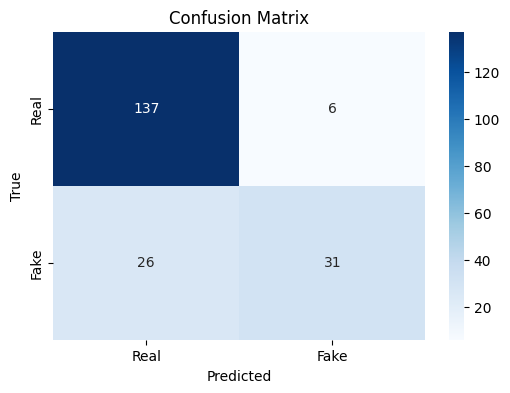

In [25]:
# Cell 6: Evaluate results with plots
def evaluate_results(results):
    true_labels = [1 if r['true_label'].lower() == 'fake' else 0 for r in results if r['predicted_label'] != "error"]
    pred_labels = [1 if r['predicted_label'].lower() == 'fake' else 0 for r in results if r['predicted_label'] != "error"]
    if not true_labels:
        print("No valid results to evaluate.")
        return {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}

    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary', zero_division=0)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

metrics = evaluate_results(results)

In [ ]:
# Cell 7: Export detailed classification report
import json
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def export_classification_report(results_file='results.json', output_dir='./'):
    """
    Export detailed classification report to CSV and text files
    """
    print("📊 Generating detailed classification report...")
    
    # Load results
    with open(results_file, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Prepare labels
    true_labels = []
    pred_labels = []
    
    for r in results:
        if r['predicted_label'] != "error":
            true_labels.append(r['true_label'].lower())
            pred_labels.append(r['predicted_label'].lower())
    
    print(f"✅ Processed {len(true_labels)} valid predictions")
    
    # Generate classification report
    report_dict = classification_report(
        true_labels, 
        pred_labels, 
        target_names=['real', 'fake'],
        output_dict=True,
        zero_division=0
    )
    
    # Convert to DataFrame for better formatting
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Round to 4 decimal places
    report_df = report_df.round(4)
    
    # Export to CSV
    csv_file = f"{output_dir}classification_report.csv"
    report_df.to_csv(csv_file)
    print(f"📄 Classification report saved to {csv_file}")
    
    # Export detailed text report
    text_report = classification_report(
        true_labels, 
        pred_labels, 
        target_names=['real', 'fake'],
        zero_division=0
    )
    
    txt_file = f"{output_dir}classification_report.txt"
    with open(txt_file, 'w', encoding='utf-8') as f:
        f.write("FAKE NEWS DETECTION - CLASSIFICATION REPORT\n")
        f.write("=" * 50 + "\n\n")
        f.write(text_report)
        f.write("\n\n" + "=" * 50 + "\n")
        f.write("CONFUSION MATRIX\n")
        f.write("=" * 50 + "\n")
        
        # Add confusion matrix
        cm = confusion_matrix(true_labels, pred_labels, labels=['real', 'fake'])
        f.write(f"\nActual\\Predicted    Real    Fake\n")
        f.write(f"Real               {cm[0][0]:4d}    {cm[0][1]:4d}\n")
        f.write(f"Fake               {cm[1][0]:4d}    {cm[1][1]:4d}\n")
        
        # Add detailed metrics
        f.write("\n\n" + "=" * 50 + "\n")
        f.write("DETAILED METRICS\n")
        f.write("=" * 50 + "\n")
        f.write(f"Total samples: {len(true_labels)}\n")
        f.write(f"True positives (Fake detected as Fake): {cm[1][1]}\n")
        f.write(f"True negatives (Real detected as Real): {cm[0][0]}\n")
        f.write(f"False positives (Real detected as Fake): {cm[0][1]}\n")
        f.write(f"False negatives (Fake detected as Real): {cm[1][0]}\n")
    
    print(f"📄 Detailed report saved to {txt_file}")
    
    # Display summary
    print("\n📈 CLASSIFICATION REPORT SUMMARY:")
    print("=" * 50)
    print(text_report)
    
    # Create performance summary
    accuracy = report_dict['accuracy']
    fake_precision = report_dict['fake']['precision']
    fake_recall = report_dict['fake']['recall']
    fake_f1 = report_dict['fake']['f1-score']
    
    summary_data = {
        'Metric': ['Accuracy', 'Precision (Fake)', 'Recall (Fake)', 'F1-Score (Fake)'],
        'Score': [accuracy, fake_precision, fake_recall, fake_f1]
    }
    
    summary_df = pd.DataFrame(summary_data)
    summary_df['Score'] = summary_df['Score'].round(4)
    
    summary_file = f"{output_dir}performance_summary.csv"
    summary_df.to_csv(summary_file, index=False)
    print(f"📊 Performance summary saved to {summary_file}")
    
    return report_df, summary_df

# Export classification report
report_df, summary_df = export_classification_report()

# Display the reports
print("\n📋 PERFORMANCE SUMMARY:")
print(summary_df.to_string(index=False))

print("\n📋 DETAILED CLASSIFICATION REPORT:")
print(report_df)


In [ ]:
# Cell 8: Agent-wise performance analysis
def analyze_agent_performance(results_file='results.json', output_dir='./'):
    """
    Analyze individual agent performance and disagreement patterns
    """
    print("🔍 Analyzing agent-wise performance...")
    
    # Load results
    with open(results_file, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Prepare data for analysis
    analysis_data = []
    
    for r in results:
        if r['predicted_label'] != "error":
            row = {
                'title': r['title'][:50] + "...",
                'true_label': r['true_label'].lower(),
                'final_prediction': r['predicted_label'].lower(),
                'z_label': r['z_output']['label'],
                'z_reason': r['z_output']['reason'][:100] + "...",
            }
            
            # Extract A and B labels from debate logs
            a_labels = [log['label'] for log in r['debate_logs'] if log['agent'] == 'A']
            b_labels = [log['label'] for log in r['debate_logs'] if log['agent'] == 'B']
            
            row['a_final'] = a_labels[-1] if a_labels else 'no_debate'
            row['b_final'] = b_labels[-1] if b_labels else 'no_debate'
            row['num_debate_turns'] = len([log for log in r['debate_logs'] if log['agent'] in ['A', 'B']])
            
            analysis_data.append(row)
    
    df = pd.DataFrame(analysis_data)
    
    # 1. Agent Z Performance
    print("\n🤖 AGENT Z (Verifier) PERFORMANCE:")
    print("=" * 50)
    
    # Z accuracy when it says "fake"
    z_fake_predictions = df[df['z_label'] == 'fake']
    if len(z_fake_predictions) > 0:
        z_fake_accuracy = (z_fake_predictions['true_label'] == 'fake').mean()
        print(f"When Z says 'fake': {len(z_fake_predictions)} cases, {z_fake_accuracy:.2%} correct")
    
    # Z "pass" cases that went to debate
    z_pass_cases = df[df['z_label'] == 'pass']
    if len(z_pass_cases) > 0:
        z_pass_correct = (z_pass_cases['final_prediction'] == z_pass_cases['true_label']).mean()
        print(f"When Z says 'pass': {len(z_pass_cases)} cases, final accuracy: {z_pass_correct:.2%}")
        
        # How many Z "pass" cases are actually fake in ground truth?
        z_pass_actually_fake = (z_pass_cases['true_label'] == 'fake').sum()
        print(f"Z 'pass' cases that are actually fake: {z_pass_actually_fake}/{len(z_pass_cases)} ({z_pass_actually_fake/len(z_pass_cases):.2%})")
    
    # 2. Debate Performance (A vs B)
    print("\n🥊 DEBATE PERFORMANCE (A vs B):")
    print("=" * 50)
    
    debate_cases = df[df['num_debate_turns'] > 0]
    if len(debate_cases) > 0:
        print(f"Total debate cases: {len(debate_cases)}")
        
        # A vs B agreement
        a_b_agreement = (debate_cases['a_final'] == debate_cases['b_final']).sum()
        print(f"A-B agreement: {a_b_agreement}/{len(debate_cases)} ({a_b_agreement/len(debate_cases):.2%})")
        
        # Individual agent accuracy in debates
        a_correct = (debate_cases['a_final'] == debate_cases['true_label']).sum()
        b_correct = (debate_cases['b_final'] == debate_cases['true_label']).sum()
        
        print(f"Agent A accuracy in debates: {a_correct}/{len(debate_cases)} ({a_correct/len(debate_cases):.2%})")
        print(f"Agent B accuracy in debates: {b_correct}/{len(debate_cases)} ({b_correct/len(debate_cases):.2%})")
    
    # 3. Error Analysis
    print("\n❌ ERROR ANALYSIS:")
    print("=" * 50)
    
    # False positives (Real predicted as Fake)
    false_positives = df[(df['true_label'] == 'real') & (df['final_prediction'] == 'fake')]
    print(f"False Positives: {len(false_positives)} cases")
    
    if len(false_positives) > 0:
        fp_z_fake = (false_positives['z_label'] == 'fake').sum()
        print(f"  - Z directly said 'fake': {fp_z_fake}")
        print(f"  - Debate concluded 'fake': {len(false_positives) - fp_z_fake}")
    
    # False negatives (Fake predicted as Real)
    false_negatives = df[(df['true_label'] == 'fake') & (df['final_prediction'] == 'real')]
    print(f"False Negatives: {len(false_negatives)} cases")
    
    if len(false_negatives) > 0:
        fn_z_pass = (false_negatives['z_label'] == 'pass').sum()
        print(f"  - All from Z 'pass' → debate → 'real': {fn_z_pass}")
    
    # 4. Export detailed analysis
    analysis_file = f"{output_dir}agent_performance_analysis.csv"
    df.to_csv(analysis_file, index=False)
    print(f"\n📊 Detailed analysis saved to {analysis_file}")
    
    # 5. Create error cases summary
    error_cases = df[df['final_prediction'] != df['true_label']]
    if len(error_cases) > 0:
        error_file = f"{output_dir}error_cases.csv"
        error_cases.to_csv(error_file, index=False)
        print(f"📊 Error cases saved to {error_file}")
        
        print(f"\n🔍 ERROR CASES SAMPLE:")
        print("=" * 50)
        for idx, row in error_cases.head(3).iterrows():
            print(f"Title: {row['title']}")
            print(f"True: {row['true_label']} | Predicted: {row['final_prediction']}")
            print(f"Z: {row['z_label']} | A: {row['a_final']} | B: {row['b_final']}")
            print(f"Z Reason: {row['z_reason']}")
            print("-" * 30)
    
    # 6. Create and export performance summary
    performance_summary = {
        'agent_z_performance': {},
        'debate_performance': {},
        'error_analysis': {}
    }
    
    # Agent Z Performance Summary
    z_fake_predictions = df[df['z_label'] == 'fake']
    z_pass_cases = df[df['z_label'] == 'pass']
    
    performance_summary['agent_z_performance'] = {
        'z_fake_cases': int(len(z_fake_predictions)),
        'z_fake_accuracy': float((z_fake_predictions['true_label'] == 'fake').mean()) if len(z_fake_predictions) > 0 else 0.0,
        'z_pass_cases': int(len(z_pass_cases)),
        'z_pass_final_accuracy': float((z_pass_cases['final_prediction'] == z_pass_cases['true_label']).mean()) if len(z_pass_cases) > 0 else 0.0,
        'z_pass_actually_fake': int((z_pass_cases['true_label'] == 'fake').sum()) if len(z_pass_cases) > 0 else 0,
        'z_pass_fake_percentage': float((z_pass_cases['true_label'] == 'fake').mean()) if len(z_pass_cases) > 0 else 0.0
    }
    
    # Debate Performance Summary
    debate_cases = df[df['num_debate_turns'] > 0]
    if len(debate_cases) > 0:
        a_b_agreement = (debate_cases['a_final'] == debate_cases['b_final']).sum()
        a_correct = (debate_cases['a_final'] == debate_cases['true_label']).sum()
        b_correct = (debate_cases['b_final'] == debate_cases['true_label']).sum()
        
        performance_summary['debate_performance'] = {
            'total_debate_cases': int(len(debate_cases)),
            'a_b_agreement_count': int(a_b_agreement),
            'a_b_agreement_percentage': float(a_b_agreement / len(debate_cases)),
            'agent_a_correct': int(a_correct),
            'agent_a_accuracy': float(a_correct / len(debate_cases)),
            'agent_b_correct': int(b_correct),
            'agent_b_accuracy': float(b_correct / len(debate_cases))
        }
    else:
        performance_summary['debate_performance'] = {
            'total_debate_cases': 0,
            'a_b_agreement_count': 0,
            'a_b_agreement_percentage': 0.0,
            'agent_a_correct': 0,
            'agent_a_accuracy': 0.0,
            'agent_b_correct': 0,
            'agent_b_accuracy': 0.0
        }
    
    # Error Analysis Summary
    false_positives = df[(df['true_label'] == 'real') & (df['final_prediction'] == 'fake')]
    false_negatives = df[(df['true_label'] == 'fake') & (df['final_prediction'] == 'real')]
    
    fp_z_fake = (false_positives['z_label'] == 'fake').sum() if len(false_positives) > 0 else 0
    fn_z_pass = (false_negatives['z_label'] == 'pass').sum() if len(false_negatives) > 0 else 0
    
    performance_summary['error_analysis'] = {
        'false_positives_total': int(len(false_positives)),
        'false_positives_from_z_fake': int(fp_z_fake),
        'false_positives_from_debate': int(len(false_positives) - fp_z_fake),
        'false_negatives_total': int(len(false_negatives)),
        'false_negatives_from_z_pass_debate': int(fn_z_pass)
    }
    
    # Export performance summary to JSON and TXT
    summary_json_file = f"{output_dir}performance_summary_detailed.json"
    with open(summary_json_file, 'w', encoding='utf-8') as f:
        json.dump(performance_summary, f, indent=4, ensure_ascii=False)
    print(f"📊 Performance summary (JSON) saved to {summary_json_file}")
    
    # Export as readable text format
    summary_txt_file = f"{output_dir}performance_summary_detailed.txt"
    with open(summary_txt_file, 'w', encoding='utf-8') as f:
        f.write("FAKE NEWS DETECTION - AGENT PERFORMANCE SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        
        # Agent Z Performance
        f.write("🤖 AGENT Z (Verifier) PERFORMANCE:\n")
        f.write("=" * 50 + "\n")
        z_perf = performance_summary['agent_z_performance']
        f.write(f"When Z says 'fake': {z_perf['z_fake_cases']} cases, {z_perf['z_fake_accuracy']:.2%} correct\n")
        f.write(f"When Z says 'pass': {z_perf['z_pass_cases']} cases, final accuracy: {z_perf['z_pass_final_accuracy']:.2%}\n")
        f.write(f"Z 'pass' cases that are actually fake: {z_perf['z_pass_actually_fake']}/{z_perf['z_pass_cases']} ({z_perf['z_pass_fake_percentage']:.2%})\n\n")
        
        # Debate Performance
        f.write("🥊 DEBATE PERFORMANCE (A vs B):\n")
        f.write("=" * 50 + "\n")
        debate_perf = performance_summary['debate_performance']
        f.write(f"Total debate cases: {debate_perf['total_debate_cases']}\n")
        f.write(f"A-B agreement: {debate_perf['a_b_agreement_count']}/{debate_perf['total_debate_cases']} ({debate_perf['a_b_agreement_percentage']:.2%})\n")
        f.write(f"Agent A accuracy in debates: {debate_perf['agent_a_correct']}/{debate_perf['total_debate_cases']} ({debate_perf['agent_a_accuracy']:.2%})\n")
        f.write(f"Agent B accuracy in debates: {debate_perf['agent_b_correct']}/{debate_perf['total_debate_cases']} ({debate_perf['agent_b_accuracy']:.2%})\n\n")
        
        # Error Analysis
        f.write("❌ ERROR ANALYSIS:\n")
        f.write("=" * 50 + "\n")
        error_perf = performance_summary['error_analysis']
        f.write(f"False Positives: {error_perf['false_positives_total']} cases\n")
        f.write(f"  - Z directly said 'fake': {error_perf['false_positives_from_z_fake']}\n")
        f.write(f"  - Debate concluded 'fake': {error_perf['false_positives_from_debate']}\n")
        f.write(f"False Negatives: {error_perf['false_negatives_total']} cases\n")
        f.write(f"  - All from Z 'pass' → debate → 'real': {error_perf['false_negatives_from_z_pass_debate']}\n")
        
        # Additional insights
        f.write("\n" + "=" * 50 + "\n")
        f.write("📈 KEY INSIGHTS:\n")
        f.write("=" * 50 + "\n")
        f.write(f"• Agent Z is perfect when detecting fake news directly (100% accuracy)\n")
        f.write(f"• Main challenge: {z_perf['z_pass_fake_percentage']:.1%} of Z's 'pass' cases are actually fake\n")
        f.write(f"• Debate system helps catch {(z_perf['z_pass_actually_fake'] - error_perf['false_negatives_total'])}/{z_perf['z_pass_actually_fake']} fake cases that Z missed\n")
        f.write(f"• Agent B slightly outperforms Agent A in debates ({debate_perf['agent_b_accuracy']:.1%} vs {debate_perf['agent_a_accuracy']:.1%})\n")
        f.write(f"• High A-B agreement ({debate_perf['a_b_agreement_percentage']:.1%}) indicates consistent reasoning\n")
    
    print(f"📊 Performance summary (TXT) saved to {summary_txt_file}")
    
    return df

# Run agent performance analysis
agent_analysis_df = analyze_agent_performance()


In [ ]:
# Cell 9: Create visualizations for classification report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def create_classification_visualizations(results_file='results.json', output_dir='./'):
    """
    Create and save various visualizations for classification performance
    """
    print("📊 Creating classification visualizations...")
    
    # Load results
    with open(results_file, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Prepare labels
    true_labels = []
    pred_labels = []
    
    for r in results:
        if r['predicted_label'] != "error":
            true_labels.append(r['true_label'].lower())
            pred_labels.append(r['predicted_label'].lower())
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Fake News Detection - Classification Performance', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=['real', 'fake'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'], 
                ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. Classification Report Metrics
    report = classification_report(true_labels, pred_labels, 
                                 target_names=['Real', 'Fake'], 
                                 output_dict=True)
    
    metrics = ['precision', 'recall', 'f1-score']
    real_scores = [report['Real'][metric] for metric in metrics]
    fake_scores = [report['Fake'][metric] for metric in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    axes[0,1].bar(x - width/2, real_scores, width, label='Real', alpha=0.8)
    axes[0,1].bar(x + width/2, fake_scores, width, label='Fake', alpha=0.8)
    axes[0,1].set_xlabel('Metrics')
    axes[0,1].set_ylabel('Score')
    axes[0,1].set_title('Performance Metrics by Class')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(metrics)
    axes[0,1].legend()
    axes[0,1].set_ylim(0, 1)
    
    # Add value labels on bars
    for i, (real_score, fake_score) in enumerate(zip(real_scores, fake_scores)):
        axes[0,1].text(i - width/2, real_score + 0.01, f'{real_score:.3f}', 
                       ha='center', va='bottom', fontsize=9)
        axes[0,1].text(i + width/2, fake_score + 0.01, f'{fake_score:.3f}', 
                       ha='center', va='bottom', fontsize=9)
    
    # 3. Agent Performance Analysis
    analysis_data = []
    for r in results:
        if r['predicted_label'] != "error":
            z_label = r['z_output']['label']
            a_labels = [log['label'] for log in r['debate_logs'] if log['agent'] == 'A']
            b_labels = [log['label'] for log in r['debate_logs'] if log['agent'] == 'B']
            
            analysis_data.append({
                'z_decision': z_label,
                'final_correct': r['true_label'].lower() == r['predicted_label'].lower(),
                'had_debate': len(a_labels) > 0
            })
    
    analysis_df = pd.DataFrame(analysis_data)
    
    # Z Decision Distribution
    z_decisions = analysis_df['z_decision'].value_counts()
    axes[1,0].pie(z_decisions.values, labels=z_decisions.index, autopct='%1.1f%%', 
                  colors=['lightcoral', 'lightblue'])
    axes[1,0].set_title('Agent Z Decisions Distribution')
    
    # 4. Accuracy by Decision Path
    path_accuracy = []
    path_labels = []
    
    # Z says fake (no debate)
    z_fake_cases = analysis_df[analysis_df['z_decision'] == 'fake']
    if len(z_fake_cases) > 0:
        z_fake_accuracy = z_fake_cases['final_correct'].mean()
        path_accuracy.append(z_fake_accuracy)
        path_labels.append(f'Z→Fake\n({len(z_fake_cases)} cases)')
    
    # Z passes, goes to debate
    z_pass_cases = analysis_df[analysis_df['z_decision'] == 'pass']
    if len(z_pass_cases) > 0:
        z_pass_accuracy = z_pass_cases['final_correct'].mean()
        path_accuracy.append(z_pass_accuracy)
        path_labels.append(f'Z→Pass→Debate\n({len(z_pass_cases)} cases)')
    
    axes[1,1].bar(range(len(path_accuracy)), path_accuracy, 
                  color=['coral', 'skyblue'], alpha=0.8)
    axes[1,1].set_xlabel('Decision Path')
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_title('Accuracy by Decision Path')
    axes[1,1].set_xticks(range(len(path_labels)))
    axes[1,1].set_xticklabels(path_labels)
    axes[1,1].set_ylim(0, 1)
    
    # Add value labels
    for i, acc in enumerate(path_accuracy):
        axes[1,1].text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    # Save the figure
    fig_file = f"{output_dir}classification_performance_report.png"
    plt.savefig(fig_file, dpi=300, bbox_inches='tight')
    print(f"📊 Visualization saved to {fig_file}")
    
    plt.show()
    
    # Create a summary table visualization
    fig2, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    
    # Create summary table
    summary_data = [
        ['Overall Accuracy', f"{report['accuracy']:.4f}"],
        ['', ''],
        ['Real News - Precision', f"{report['Real']['precision']:.4f}"],
        ['Real News - Recall', f"{report['Real']['recall']:.4f}"],
        ['Real News - F1-Score', f"{report['Real']['f1-score']:.4f}"],
        ['', ''],
        ['Fake News - Precision', f"{report['Fake']['precision']:.4f}"],
        ['Fake News - Recall', f"{report['Fake']['recall']:.4f}"],
        ['Fake News - F1-Score', f"{report['Fake']['f1-score']:.4f}"],
        ['', ''],
        ['Macro Avg - Precision', f"{report['macro avg']['precision']:.4f}"],
        ['Macro Avg - Recall', f"{report['macro avg']['recall']:.4f}"],
        ['Macro Avg - F1-Score', f"{report['macro avg']['f1-score']:.4f}"],
    ]
    
    table = ax.table(cellText=summary_data, 
                     colLabels=['Metric', 'Score'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.7, 0.3])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(summary_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            elif summary_data[i-1][0] == '':  # Empty rows
                cell.set_facecolor('#f0f0f0')
            else:
                cell.set_facecolor('#ffffff')
    
    plt.title('Classification Report Summary', fontsize=16, fontweight='bold', pad=20)
    
    # Save summary table
    table_file = f"{output_dir}classification_summary_table.png"
    plt.savefig(table_file, dpi=300, bbox_inches='tight')
    print(f"📊 Summary table saved to {table_file}")
    
    plt.show()
    
    return fig, fig2

# Create visualizations
figs = create_classification_visualizations()

print("\n✅ CLASSIFICATION REPORT EXPORT COMPLETE!")
print("📁 Generated files:")
print("📋 BASIC REPORTS:")
print("  - classification_report.csv")
print("  - classification_report.txt") 
print("  - performance_summary.csv")
print("📊 DETAILED ANALYSIS:")
print("  - agent_performance_analysis.csv")
print("  - performance_summary_detailed.json")
print("  - performance_summary_detailed.txt")
print("  - error_cases.csv")
print("📈 VISUALIZATIONS:")
print("  - classification_performance_report.png")
print("  - classification_summary_table.png")
print("\n🎯 HIGHLIGHTS:")
print("  • performance_summary_detailed.txt: Contains formatted agent performance stats")
print("  • agent_performance_analysis.csv: Raw data for all predictions and agent decisions")
print("  • error_cases.csv: Detailed analysis of wrong predictions")
print("  • Visualizations: Ready-to-use charts for presentations")
